In [1]:
import abc
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import torch
import numpy as np
import seaborn as sns
from fil_torch import FIL_Linear_torch, FIL_Logistic_torch, compute_accuracy, iterative_reweighted_fil

## Toy Dataset with Linear Model

/work/fil_torch.py:67: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  theta = torch.solve(b[:, None], XTX)[0].squeeze(1)
coefficients:tensor([-3.0246,  5.4880])
fisher info loss: tensor([1.8121, 2.5218, 1.6306, 1.6664, 1.2495, 0.4685, 0.2334, 0.4418, 0.5215,
        1.5932])


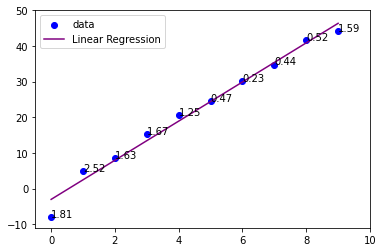

In [2]:
# define dataset
X_linear = np.arange(10)
y_linear = X_linear * 5 + np.random.normal(size=len(X_linear))
y_linear[0] = -8 # extraneous outlier


train_data = {"features": torch.from_numpy(add_bias(X_linear)).float(), "targets": torch.from_numpy(y_linear).float()}

model = FIL_Linear_torch()

model.train(train_data)


print("coefficients:{}".format(model.get_params()))

# # plot data with regression line

all_fils =  model.compute_all_fils()

print('fisher info loss:', all_fils)


fig, ax = plt.subplots()
ax.scatter(X_linear, y_linear, label="data", color="blue")
ax.plot(X_linear, model.predict(torch.from_numpy(add_bias(X_linear)).float(), regression=True), label="Linear Regression", color="purple")
plt.legend()

for i, txt in enumerate(all_fils):
    ax.annotate(round(txt.item(),2), (X_linear[i], y_linear[i]))
# plt.title("FIL on toy dataset with Linear Regression")
plt.xlim(left=-0.5,right=10)
plt.ylim(bottom=-11,top=50)

# plt.savefig("figs/linear_toy.png", dpi=1200, bbox_inches="tight")
plt.show()



In [3]:
# try some new data!

print(model.fil(torch.tensor([[1, 10]]).float(),torch.tensor([1000]).float()))
print(model.fil(torch.tensor([[1, 10]]).float(),torch.tensor([50]).float()))
print(model.fil(torch.tensor([[1, 10]]).float(),torch.tensor([10]).float()))

tensor([334.9891])
tensor([1.8087])
tensor([15.6601])


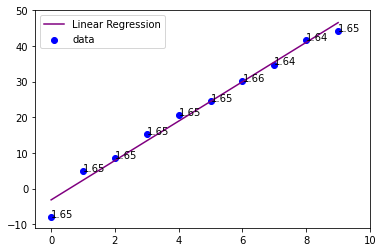

In [4]:
model = FIL_Linear_torch()
res = iterative_reweighted_fil(model, train_data, train_data, 15, l2=0, regression=True)


fig, ax = plt.subplots()
ax.plot(X_linear, model.predict(torch.from_numpy(add_bias(X_linear)).float(), regression=True), label="Linear Regression", color="purple")

ax.scatter(X_linear, y_linear, label="data", color="blue")
plt.legend()

all_fils = model.compute_all_fils()

for i, txt in enumerate(all_fils):
    ax.annotate(round(txt.item(),2), (X_linear[i], y_linear[i]))
plt.xlim(left=-0.5,right=10)
plt.ylim(bottom=-11,top=50)
# plt.savefig("figs/linear_toy_reweighted.png", dpi=1200, bbox_inches="tight")
plt.show()

## Toy Dataset with Logistic Model

coefficients:[ 1.325786  -2.0052445  2.0286987]
coefficients:[ 1.325786  -2.0052445  2.0286987]
fisher info loss: tensor([2.0362, 1.6328, 1.2868, 1.0331, 0.9181, 1.6495, 1.2015, 0.9266, 0.9746,
        1.1618, 3.4903], grad_fn=<CopyBackwards>)


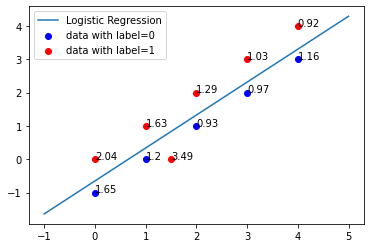

In [5]:
# define dataset
X = np.array([[x, x] for x in range(5)] + [[x, x-1] for x in range(5)])
X = np.vstack((X, np.array([[1.5, 0]]))) # Add one atypical data point 
y = np.array([1] * 5 + [0] * 5 + [1]) # labels


train_data = {"features": torch.from_numpy(add_bias(X)).float(), "targets": torch.from_numpy(y).float()}

model = FIL_Logistic_torch()

model.train(train_data, l2=0.01)

print("coefficients:{}".format(model.get_params()))

b, w1, w2 = model.get_params()
c = -b/w2
m = -w1/w2

# plot the data and the classification with the decision boundary.
xmin, xmax = -1, 5
ymin, ymax = -1, 5
xd = np.array([xmin, xmax])
yd = m*xd+c


print("coefficients:{}".format(model.get_params()))


all_fils =  model.compute_all_fils()

print('fisher info loss:', all_fils)

fig, ax = plt.subplots()

ax.plot(xd, yd, label="Logistic Regression")
x_0 = X[y==0]
x_1 = X[y==1]
ax.scatter(x_0[:,0], x_0[:,1], label="data with label=0", color="blue")
ax.scatter(x_1[:,0], x_1[:,1], label="data with label=1", color="red")

# ax.scatter(X[:,0], X[:,1], color=[col(y_val) for y_val in y])

for i, txt in enumerate(all_fils):
    ax.annotate(round(txt.item(),2), (X[i][0], X[i][1]))

plt.legend()
# plt.savefig("figs/logistic_toy.png", dpi=1200, bbox_inches="tight")
plt.show()



In [6]:
model = FIL_Logistic_torch()
res = iterative_reweighted_fil(model, train_data, train_data, 15, l2=0.01, regression=False)

print(res)

{'weights': [0.5686322450637817, 0.7587141394615173, 1.0340908765792847, 1.318194031715393, 1.2921321392059326, 0.7157686948776245, 0.9651575088500977, 1.3755722045898438, 1.478515386581421, 1.1248550415039062, 0.36836791038513184], 'etas': [2.0362069606781006, 1.632821798324585, 1.2868348360061646, 1.0331315994262695, 0.9181869626045227, 1.6495600938796997, 1.2015032768249512, 0.9266965389251709, 0.9746230840682983, 1.1618332862854004, 3.4903225898742676], 'weighted_etas': [1.540513515472412, 1.540518879890442, 1.5405256748199463, 1.5405328273773193, 1.5405299663543701, 1.5405137538909912, 1.5405091047286987, 1.540497064590454, 1.5404917001724243, 1.5404956340789795, 1.5405126810073853], 'eta_maxes': [3.4903225898742676, 1.6465567350387573, 1.5790685415267944, 1.552392601966858, 1.543952465057373, 1.5415661334991455, 1.5408350229263306, 1.5406132936477661, 1.540542483329773, 1.5405255556106567, 1.5406427383422852, 1.5405616760253906, 1.5408048629760742, 1.5406699180603027, 1.540557742

In [7]:
import numpy as np
weights = [0.5686313509941101, 0.7587074637413025, 1.0340685844421387, 1.3181416988372803, 1.292080283164978, 0.7157686948776245, 0.9651613831520081, 1.375602126121521, 1.4785760641098022, 1.124894142150879, 0.368368536233902]
fils = [2.0363, 1.6329, 1.2869, 1.0331, 0.9182, 1.6497, 1.2016, 0.9267, 0.9746,
        1.1618, 3.4904]
print(np.array(weights)*np.array(fils))

[1.15790402 1.23889342 1.33074286 1.36177219 1.18638812 1.18080362
 1.15973792 1.27477049 1.44102023 1.30690201 1.28575354]


coefficients:[ 1.1112587 -2.7080529  2.8737264]
fisher info loss: tensor([1.5405, 1.5405, 1.5405, 1.5405, 1.5405, 1.5405, 1.5405, 1.5405, 1.5405,
        1.5405, 1.5405], grad_fn=<CopyBackwards>)


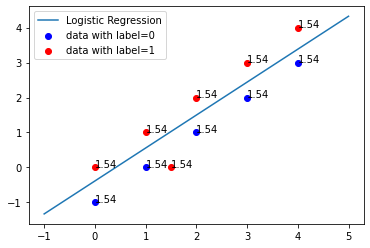

In [8]:
b, w1, w2 = model.get_params()
c = -b/w2
m = -w1/w2

# plot the data and the classification with the decision boundary.
xmin, xmax = -1, 5
ymin, ymax = -1, 5
xd = np.array([xmin, xmax])
yd = m*xd+c


print("coefficients:{}".format(model.get_params()))


all_fils =  model.compute_all_fils()

print('fisher info loss:', all_fils)

fig, ax = plt.subplots()

ax.plot(xd, yd, label="Logistic Regression")
x_0 = X[y==0]
x_1 = X[y==1]
ax.scatter(x_0[:,0], x_0[:,1], label="data with label=0", color="blue")
ax.scatter(x_1[:,0], x_1[:,1], label="data with label=1", color="red")


for i, txt in enumerate(all_fils):
    ax.annotate(round(txt.item(),2), (X[i][0], X[i][1]))

plt.legend()
# plt.savefig("figs/logistic_toy_reweighted.png", dpi=1200, bbox_inches="tight")
plt.show()

In [9]:
model.get_params()

array([ 1.1112587, -2.7080529,  2.8737264], dtype=float32)

## MNIST Dataset with Linear Model

In [10]:
# num_samples = 100
# data = {"features": features[:num_samples], "targets": targets[:num_samples]}
train_data, orig_img = load_mnist_dataset(train=True, num_classes=2)
train_data["targets"][train_data["targets"] == 0] = -1

test_data, _ = load_mnist_dataset(train=False, num_classes=2)
test_data["targets"][test_data["targets"] == 0] = -1

train_data, mapping = pca(train_data, num_dims=20)
test_data, _ = pca(test_data, mapping=mapping)

model = FIL_Linear_torch()

model.train(train_data)

all_fils =  model.compute_all_fils()

/work/utils.py:97: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  _, projection = torch.symeig(covariance, eigenvectors=True)


<Figure size 432x288 with 0 Axes>

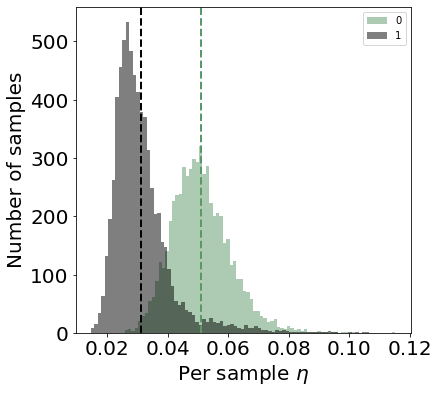

In [11]:
plt.clf()
labels = ["0", "1"]
n_class = len(labels)
colors = sns.cubehelix_palette(n_class, start=2, rot=0, dark=0, light=.5)

plt.figure(figsize=(6, 6))

targets = train_data["targets"].clone().detach().numpy()
targets[targets==-1]=0
all_fils = all_fils.detach().numpy()
all_fils_class = [all_fils[targets == c] for c in range(n_class)]

for c in range(n_class):
    plt.hist(
        all_fils_class[c], bins=80, color=colors[c], alpha=0.5, label=labels[c])
    plt.axvline(
        all_fils_class[c].mean(), color=colors[c], linestyle='dashed', linewidth=2)
plt.xlabel("Per sample $\eta$", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Number of samples", fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
# plt.savefig("figs/linear_mnist_hist.png", dpi=1200, bbox_inches="tight")

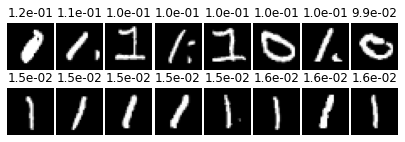

In [12]:
# Most and least leaked images:
# The results are the same as the paper's
sorted_etas = sorted(
    zip(all_fils, range(len(all_fils))), key=lambda x: x[0], reverse=True)

ims = orig_img.squeeze()
n_ims = 8
f, axarr = plt.subplots(2, n_ims, figsize=(7, 2.2))
f.subplots_adjust(wspace=0.05)
for priv in [False, True]:
    for i in range(n_ims):
        ax = axarr[int(priv), i]
        idx = -(i + 1) if priv else i
        im = sorted_etas[idx][1]
        image = ims[im, ...]
        if image.ndim == 3:
            image = image.permute(1, 2, 0)
        ax.imshow(image, cmap='gray')
        ax.axis("off")
        title = "{:.1e}".format(sorted_etas[idx][0])
        ax.set_title(title, fontsize=12)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# plt.savefig("figs/linear_mnist.png", dpi=1200, bbox_inches="tight")

In [13]:
model = FIL_Linear_torch()
linear_res = iterative_reweighted_fil(model, train_data, test_data, 15, 0, regression=False)
print(linear_res["eta_stds"])

[0.013790183700621128, 0.006163668818771839, 0.0036045073065906763, 0.0021051806397736073, 0.0012140243779867887, 0.0006934726261533797, 0.0003938587324228138, 0.00022273628565017134, 0.00012570655962917954, 7.083549280650914e-05, 3.994879443780519e-05, 2.246783515147399e-05, 1.2688887181866448e-05, 7.2093839662557e-06, 4.04461434300174e-06, 2.3051295556797413e-06]


## MNIST Dataset with Logistic Model

In [14]:
train_data, orig_img = load_mnist_dataset(train=True, num_classes=2)
test_data, _ = load_mnist_dataset(train=False, num_classes=2)


train_data, mapping = pca(train_data, num_dims=20)
test_data, _ = pca(test_data, mapping=mapping)


model = FIL_Logistic_torch()

model.train(train_data, l2=8e-4)

all_fils_lr =  model.compute_all_fils()

<Figure size 432x288 with 0 Axes>

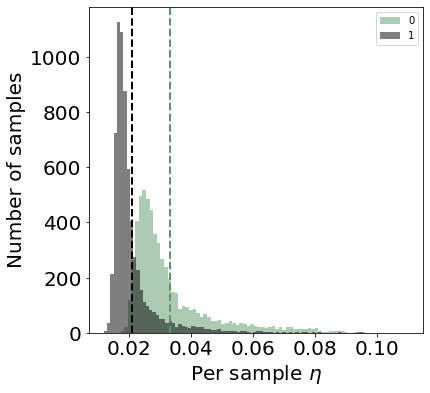

In [15]:
plt.clf()
labels = ["0", "1"]
n_class = len(labels)
colors = sns.cubehelix_palette(n_class, start=2, rot=0, dark=0, light=.5)

plt.figure(figsize=(6, 6))

targets = train_data["targets"].detach().numpy()
all_fils_lr = all_fils_lr.detach().numpy()
all_fils_class = [all_fils_lr[targets == c] for c in range(n_class)]

for c in range(n_class):
    plt.hist(
        all_fils_class[c], bins=80, color=colors[c], alpha=0.5, label=labels[c])
    plt.axvline(
        all_fils_class[c].mean(), color=colors[c], linestyle='dashed', linewidth=2)
plt.xlabel("Per sample $\eta$", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Number of samples", fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
# plt.savefig("figs/logistic_mnist_hist.png", dpi=1200, bbox_inches="tight")

In [16]:
all_fils_lr

array([0.02074889, 0.0195004 , 0.02214793, ..., 0.03134299, 0.03555711,
       0.02076194], dtype=float32)

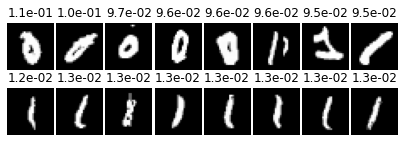

In [17]:
# Most and least leaked images:
# The results are the same as the paper's
sorted_etas = sorted(
    zip(all_fils_lr, range(len(all_fils_lr))), key=lambda x: x[0], reverse=True)

ims = orig_img.squeeze()
n_ims = 8
f, axarr = plt.subplots(2, n_ims, figsize=(7, 2.2))
f.subplots_adjust(wspace=0.05)
for priv in [False, True]:
    for i in range(n_ims):
        ax = axarr[int(priv), i]
        idx = -(i + 1) if priv else i
        im = sorted_etas[idx][1]
        image = ims[im, ...]
        if image.ndim == 3:
            image = image.permute(1, 2, 0)
        ax.imshow(image, cmap='gray')
        ax.axis("off")
        title = "{:.1e}".format(sorted_etas[idx][0])
        ax.set_title(title, fontsize=12)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# plt.savefig("figs/logistic_mnist.png", dpi=1200, bbox_inches="tight")

In [18]:
model = FIL_Logistic_torch()
logistic_res = iterative_reweighted_fil(model, train_data, test_data, 15, l2=8e-4, regression=False)

<Figure size 432x288 with 0 Axes>

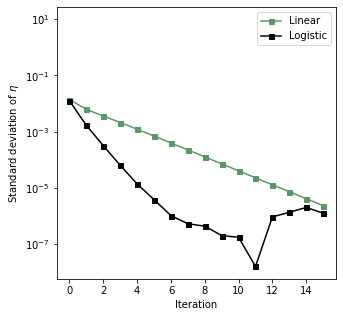

In [19]:
stds = np.array([linear_res["eta_stds"], logistic_res["eta_stds"]])
iterations = np.arange(stds.shape[1])


line_plot(
    stds, iterations, legend=["Linear", "Logistic"],
    xlabel="Iteration", ylabel="Standard deviation of $\eta$",
    ylog=True,
    size=(5, 5))
    # filename="figs/mnist_eta_std_vs_iterations.png")



In [20]:
for results, model in [(linear_res, "linear"), (logistic_res, "logistic")]:
    em = results["eta_means"]
    std = results["eta_stds"]
    acc = results["test_accs"]
    print("="*20)
    print(f"MNIST {model}")
    print(f"Pre IRFP eta {em[0]:.3f}, std {std[0]:.3f}, test accuracy {acc[0]:.3f}")
    print(f"Post IRFP eta {em[-1]:.3f}, std {std[-1]:.3f}, test accuracy {acc[-1]:.3f}")


MNIST linear
Pre IRFP eta 0.040, std 0.014, test accuracy 1.000
Post IRFP eta 0.047, std 0.000, test accuracy 0.998
MNIST logistic
Pre IRFP eta 0.027, std 0.012, test accuracy 0.998
Post IRFP eta 0.024, std 0.000, test accuracy 0.997


## Attribute Inference Attacks

The authors consider protecting from inference attacks is a good application of FIL and IRFIL, but this kind of application is not what we focued in this project. Therefore, we just learned and reproduced the experiments with author's implementation. Since the experiments are too much, too long and not relevent to what we've done so far, we put it in another branch of our repo.


See [iwpc_experiments.ipynb](https://github.com/charlotte12l/am207_fisher/blob/iwpc/attacking_iwpc.ipynb) for more details.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3414c8e1-e8f2-444e-be94-05f51d01b06b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>